# LETID - Passivated Wafer

Example: LETID progression in passivated wafer

Author: Joe Karas | joseph.karas@nrel.gov

2023
***

This example shows how to simulate an accelerated test performed on a well-passivated Si wafer, rather than a solar cell.
In a well-passivated wafer, carrier injection ($\Delta n$) is linearly proportional to carrier lifetime, assuming surface recombination velocity can be approximated to be zero.

LETID and boron-oxygen LID defect transitions are known to accelerate with increased carrier injection, by term $\Delta n^{x_{ij}}$, where $x_{ij}$ is different for each transition $i \rightarrow j$ and is related to the stoichiometric involvement of excess carriers in the defect reaction.

**Requirements:**
- `pandas`, `numpy`, `matplotlib`, `scipy`

**Objectives:**
1. Define necessary wafer device parameters
2. Define necessary degradation parameters: degraded lifetime and defect states
3. Create timeseries of temperature and injection
4. Run through timeseries, calculating defect states
5. Calculate device degradation and plot


In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.3.3

In [1]:
from pvdeg import letid, collection, utilities, DATA_DIR

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Device parameters
For modeling a wafer, we don't need as many device parameters. Wafer thickness, lifetime, and an optical generation profile, which allows us to calculate generation current, which we take to be device current assuming surface recombination is very low. 

In [2]:
wafer_thickness = 180  # um
tau = 350  # us, lifetime of the wafer for demonstration purposes

generation_df = pd.read_excel(
    os.path.join(DATA_DIR, "PVL_GenProfile.xlsx"), header=0
)  # this is an optical generation profile generated by PVLighthouse's OPAL2 default model for 1-sun, normal incident AM1.5 sunlight on a 180-um thick SiNx-coated, pyramid-textured wafer.
generation = generation_df["Generation (cm-3s-1)"]
depth = generation_df["Depth (um)"]

j_gen = collection.generation_current(generation, depth)

## Degradation parameters
Here we'll model LETID under 0.5-sun, open-circuit injection. In a passivated wafer, recombination per volume ($\frac{\Delta n}{\tau}$) must equal generation per volume ($\frac{Jq}{W}$), which gives $\Delta n = \frac{Jq\tau}{W}$

The term $\Delta n^{x_{ij}}$ is calculated for wafers by the function ```letid.carrier_factor_wafer```, which adjusts the rate of the transition $i \rightarrow j$ for $\Delta n$.

Since kinetic parameters are taken from literature that may have used different $\Delta n$, we adjust transitions by the ratio $\frac{\Delta n}{\Delta n_{lit}}$.

See [Repins *et al.* 2023](https://doi.org/10.1557/s43577-022-00438-8) for more details.

In [3]:
mechanism_params = utilities.get_kinetics("repins")
injection = 0.5  #

### Demonstrate calculation of dn^x_ij
1. Calculate $\Delta n$ of the wafer

In [4]:
from scipy.constants import elementary_charge as q  # Elementary charge, C

dn = (
    ((j_gen * 0.001 * 10000 * injection) * (tau * 1e-6)) / (wafer_thickness * 1e-6) / q
)  # calculate excess carrier density
dn

2.5706584437713456e+21

2. Calculate $\Delta n_{lit}$, the excess carrier density from the literature experiments where kinetic parameters were determined.
Assuming literature experiments were carried out on cells, this requires using the `calc_dn` function

In [5]:
from scipy.constants import convert_temperature

transition = "bc"  # for this example we'll look at the B -> C transition

meas_tau = mechanism_params[f"tau_{transition}"]
meas_temp = mechanism_params[f"temperature_{transition}"]
meas_temp = convert_temperature(meas_temp, "K", "C")
meas_suns = mechanism_params[f"suns_{transition}"]
meas_jsc = 40
meas_wafer_thickness = mechanism_params[f"thickness_{transition}"]
meas_srv = mechanism_params[f"srv_{transition}"]
meas_structure = mechanism_params[f"structure_{transition}"]

dn_lit = letid.calc_dn(
    meas_tau,
    meas_temp,
    meas_suns,
    meas_jsc,
    wafer_thickness=meas_wafer_thickness,
    s_rear=meas_srv,
)
dn_lit

7.064647199192719e+20

3. Return the exponent $x_{ij}$ of the transition in question


In [6]:
exponent = mechanism_params[f"x_{transition}"]
exponent

1.2

4. Calculate $(\frac{\Delta n}{\Delta n_{lit}})^{x_{ij}}$. This is the acceleration factor of the transition due to excess carriers.


In [7]:
(dn / dn_lit) ** exponent

4.711342509616992

In [8]:
# the "carrier_factor_wafer" function yields the same result

letid.carrier_factor_wafer(
    tau, transition, injection, j_gen, wafer_thickness, mechanism_params
)

4.711342509616992

## Degradation parameters
To model the device's degradation, we need to define several more important quantities about the degradation the device will experience. These include undegraded and degraded lifetime (in $\mu s$), and starting defect state percentages

In [9]:
tau_0 = 350  # us, carrier lifetime in non-degraded states, e.g. LETID/LID states A or C
tau_deg = 41  # us, carrier lifetime in fully-degraded state, e.g. LETID/LID state B

In [10]:
# starting defect state percentages
nA_0 = 100
nB_0 = 0
nC_0 = 0

mechanism_params = utilities.get_kinetics("repins")
print(mechanism_params)

{'mechanism': 'LETID', 'v_ab': 46700000.0, 'v_ba': 4.7e-25, 'v_bc': 19900000.0, 'v_cb': 0.0, 'ea_ab': 0.827, 'ea_ba': -1.15, 'ea_bc': 0.871, 'ea_cb': 0.0, 'suns_ab': 1.0, 'suns_bc': 1.0, 'temperature_ab': 410, 'temperature_bc': 410, 'tau_ab': 75, 'tau_bc': 75, 'x_ab': 1, 'x_ba': 1.7, 'x_bc': 1.2, 'structure_ab': 'cell', 'structure_bc': 'cell', 'thickness_ab': 200, 'thickness_bc': 200, 'srv_ab': 90, 'srv_bc': 90, 'doi': 'doi:10.1557/s43577-022-00438-8', 'comments': ''}


## Set up timeseries
In this example, we are going to model a wafer exposed to 0.5 suns illumination at $125\degree C$ for 24 hours, and compare to experimental data from [Wyller *et al.*  2021](https://doi.org/10.1109/JPHOTOV.2021.3078367).

In [11]:
temperature = 125  # degrees celsius
suns = 0.5  # "suns" of injection, e.g 1-sun illumination at open circuit would be 1; dark current injection is given as a fraction of Isc, e.g., injecting Isc would be 1. For this example we assume injection is 0.1*Isc.

timesteps = pd.date_range(
    start="2022-01-01 00:00:00", end="2022-01-02 00:00:00", freq="S"
)  # three weeks of 1-minute interval timesteps. In general, we should select small timesteps unless we are sure defect reactions are proceeding very slowly
timesteps = pd.DataFrame(timesteps, columns=["Datetime"])

temps = np.full(len(timesteps), temperature)
injection = np.full(len(timesteps), suns)

timesteps["Temperature"] = temps
timesteps["Injection"] = injection

timesteps[["NA", "NB", "NC", "tau"]] = (
    np.nan
)  # create columns for defect state percentages and lifetime, fill with NaNs for now, to fill iteratively below

timesteps.loc[0, ["NA", "NB", "NC"]] = (
    nA_0,
    nB_0,
    nC_0,
)  # assign first timestep defect state percentages
timesteps.loc[0, "tau"] = letid.tau_now(
    tau_0, tau_deg, nB_0
)  # calculate tau for the first timestep

In [12]:
timesteps

,Datetime,Temperature,Injection,NA,NB,NC,tau
0,2022-01-01 00:00:00,125,0.5,100.0,0.0,0.0,350.0
1,2022-01-01 00:00:01,125,0.5,NaN,NaN,NaN,NaN
2,2022-01-01 00:00:02,125,0.5,NaN,NaN,NaN,NaN
3,2022-01-01 00:00:03,125,0.5,NaN,NaN,NaN,NaN
4,2022-01-01 00:00:04,125,0.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
86396,2022-01-01 23:59:56,125,0.5,NaN,NaN,NaN,NaN
86397,2022-01-01 23:59:57,125,0.5,NaN,NaN,NaN,NaN
86398,2022-01-01 23:59:58,125,0.5,NaN,NaN,NaN,NaN
86399,2022-01-01 23:59:59,125,0.5,NaN,NaN,NaN,NaN


## Run through timesteps
Since each timestep depends on the preceding timestep, we need to calculate in a loop. This will take a few minutes depending on the length of the timeseries.

In [13]:
for index, timestep in timesteps.iterrows():

    # first row tau has already been assigned
    if index == 0:
        pass

    # loop through rows, new tau calculated based on previous NB. Reaction proceeds based on new tau.
    else:
        n_A = timesteps.at[index - 1, "NA"]
        n_B = timesteps.at[index - 1, "NB"]
        n_C = timesteps.at[index - 1, "NC"]

        tau = letid.tau_now(tau_0, tau_deg, n_B)
        j_gen = j_gen

        temperature = timesteps.at[index, "Temperature"]
        injection = timesteps.at[index, "Injection"]

        # calculate defect reaction kinetics: reaction constant and carrier concentration factor.
        k_AB = letid.k_ij(
            mechanism_params["v_ab"], mechanism_params["ea_ab"], temperature
        )
        k_BA = letid.k_ij(
            mechanism_params["v_ba"], mechanism_params["ea_ba"], temperature
        )
        k_BC = letid.k_ij(
            mechanism_params["v_bc"], mechanism_params["ea_bc"], temperature
        )
        k_CB = letid.k_ij(
            mechanism_params["v_cb"], mechanism_params["ea_cb"], temperature
        )

        x_ab = letid.carrier_factor_wafer(
            tau, "ab", injection, j_gen, wafer_thickness, mechanism_params
        )
        x_ba = letid.carrier_factor_wafer(
            tau, "ba", injection, j_gen, wafer_thickness, mechanism_params
        )
        x_bc = letid.carrier_factor_wafer(
            tau, "bc", injection, j_gen, wafer_thickness, mechanism_params
        )
        # x_cb there is no known excess carrier acceleration factor for the c->b transition

        # calculate the instantaneous change in NA, NB, and NC
        dN_Adt = (k_BA * n_B * x_ba) - (k_AB * n_A * x_ab)
        dN_Bdt = (
            (k_AB * n_A * x_ab) + (k_CB * n_C) - ((k_BA * x_ba + k_BC * x_bc) * n_B)
        )
        dN_Cdt = (k_BC * n_B * x_bc) - (k_CB * n_C)

        t_step = (
            timesteps.at[index, "Datetime"] - timesteps.at[index - 1, "Datetime"]
        ).total_seconds()

        # assign new defect state percentages
        timesteps.at[index, "NA"] = n_A + dN_Adt * t_step
        timesteps.at[index, "NB"] = n_B + dN_Bdt * t_step
        timesteps.at[index, "NC"] = n_C + dN_Cdt * t_step

## Finish calculating degraded device parameters.
Now that we have calculated defect states, we can calculate all the quantities that depend on defect states. Since this is a wafer, device parameters like Jsc, Voc, FF, etc., aren't really appropriate

For wafers, results are often presented in terms of normalized defect density (NDD), where

$NDD(t) = \frac{1}{\tau (t)} - \frac{1}{\tau _0}$

In [14]:
timesteps["tau"] = letid.tau_now(tau_0, tau_deg, timesteps["NB"])

timesteps["NDD"] = letid.calc_ndd(timesteps["tau"].iloc[0], timesteps["tau"])

timesteps["time (s)"] = (
    timesteps["Datetime"] - timesteps.iloc[0]["Datetime"]
).dt.total_seconds()  # create a column for seconds elapsed

In [15]:
timesteps

,Datetime,Temperature,Injection,NA,NB,NC,tau,NDD,time (s)
0,2022-01-01 00:00:00,125,0.5,1.000000e+02,0.000000e+00,0.000000,350.000000,0.000000,0.0
1,2022-01-01 00:00:01,125,0.5,9.942175e+01,5.782480e-01,0.000000,335.383917,0.000125,1.0
2,2022-01-01 00:00:02,125,0.5,9.887086e+01,1.128658e+00,0.000486,322.562131,0.000243,2.0
3,2022-01-01 00:00:03,125,0.5,9.834396e+01,1.654652e+00,0.001392,311.192917,0.000356,3.0
4,2022-01-01 00:00:04,125,0.5,9.783834e+01,2.159000e+00,0.002663,301.019637,0.000465,4.0
...,...,...,...,...,...,...,...,...,...
86396,2022-01-01 23:59:56,125,0.5,5.771633e-34,3.352902e-27,100.000000,350.000000,0.000000,86396.0
86397,2022-01-01 23:59:57,125,0.5,5.766526e-34,3.349935e-27,100.000000,350.000000,0.000000,86397.0
86398,2022-01-01 23:59:58,125,0.5,5.761423e-34,3.346971e-27,100.000000,350.000000,0.000000,86398.0
86399,2022-01-01 23:59:59,125,0.5,5.756325e-34,3.344009e-27,100.000000,350.000000,0.000000,86399.0


## Plot the results

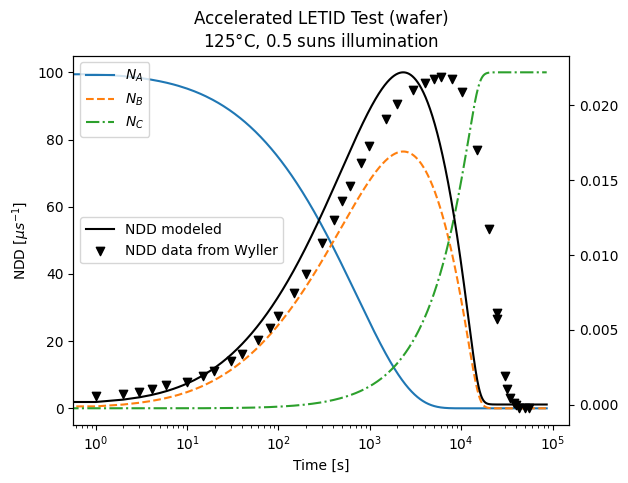

In [16]:
from cycler import cycler

plt.style.use("default")

fig, ax = plt.subplots()

ax.set_prop_cycle(
    cycler("color", ["tab:blue", "tab:orange", "tab:green"])
    + cycler("linestyle", ["-", "--", "-."])
)

ax.plot(timesteps["time (s)"], timesteps[["NA", "NB", "NC"]].values)
ax.legend(labels=["$N_A$", "$N_B$", "$N_C$"], loc="upper left")
ax.set_ylabel("Defect state percentages [%]")
ax.set_xlabel("Time [s]")

ax2 = ax.twinx()
c_norm = 1.35  # Normalization constants "C_norm". See Repins 2023 for details
ax2.plot(
    timesteps["time (s)"], timesteps["NDD"] * c_norm, c="black", label="NDD modeled"
)
ax.set_ylabel("NDD [$\mu s^{-1}$]")

data = pd.read_csv("example data\wyller data.csv", header=0)
filtered = data[data["Series"] == "0.5 sun 125C"]
ax2.scatter(
    filtered["X"], filtered["Y"], label="NDD data from Wyller", marker="v", c="black"
)

ax2.legend(loc="center left")

ax.set_xscale("log")

ax.set_title(
    "Accelerated LETID Test (wafer)\n"
    rf"{temperature}$\degree$C, {suns} suns illumination"
)

plt.show()

## Compare model results to experimental data
Experimental data (0.5 suns, 125&deg;C, 150&deg;C, 175&deg;C) from [Wyller 2021](https://doi.org/10.1109/JPHOTOV.2021.3078367).
Comparison with experimental data requires normalization constant ($C_{norm}$), which relates NDD to $N_B$ as described in [Repins 2023](https://doi.org/10.1557/s43577-022-00438-8).

In [17]:
temperatures = [125, 150, 175]  # degrees celsius

In [18]:
timesteps125 = timesteps

In [19]:
temperature = temperatures[1]  # degrees celsius
suns = 0.5  # "suns" of injection, e.g 1-sun illumination at open circuit would be 1; dark current injection is given as a fraction of Isc, e.g., injecting Isc would be 1. For this example we assume injection is 0.1*Isc.

timesteps = pd.date_range(
    start="2022-01-01 00:00:00", end="2022-01-02 00:00:00", freq="S"
)  # three weeks of 1-minute interval timesteps. In general, we should select small timesteps unless we are sure defect reactions are proceeding very slowly
timesteps = pd.DataFrame(timesteps, columns=["Datetime"])

temps = np.full(len(timesteps), temperature)
injection = np.full(len(timesteps), suns)

timesteps["Temperature"] = temps
timesteps["Injection"] = injection

timesteps[["NA", "NB", "NC", "tau"]] = (
    np.nan
)  # create columns for defect state percentages and lifetime, fill with NaNs for now, to fill iteratively below

timesteps.loc[0, ["NA", "NB", "NC"]] = (
    nA_0,
    nB_0,
    nC_0,
)  # assign first timestep defect state percentages
timesteps.loc[0, "tau"] = letid.tau_now(
    tau_0, tau_deg, nB_0
)  # calculate tau for the first timestep

In [20]:
for index, timestep in timesteps.iterrows():

    # first row tau has already been assigned
    if index == 0:
        pass

    # loop through rows, new tau calculated based on previous NB. Reaction proceeds based on new tau.
    else:
        n_A = timesteps.at[index - 1, "NA"]
        n_B = timesteps.at[index - 1, "NB"]
        n_C = timesteps.at[index - 1, "NC"]

        tau = letid.tau_now(tau_0, tau_deg, n_B)
        j_gen = j_gen

        temperature = timesteps.at[index, "Temperature"]
        injection = timesteps.at[index, "Injection"]

        # calculate defect reaction kinetics: reaction constant and carrier concentration factor.
        k_AB = letid.k_ij(
            mechanism_params["v_ab"], mechanism_params["ea_ab"], temperature
        )
        k_BA = letid.k_ij(
            mechanism_params["v_ba"], mechanism_params["ea_ba"], temperature
        )
        k_BC = letid.k_ij(
            mechanism_params["v_bc"], mechanism_params["ea_bc"], temperature
        )
        k_CB = letid.k_ij(
            mechanism_params["v_cb"], mechanism_params["ea_cb"], temperature
        )

        x_ab = letid.carrier_factor_wafer(
            tau, "ab", injection, j_gen, wafer_thickness, mechanism_params
        )
        x_ba = letid.carrier_factor_wafer(
            tau, "ba", injection, j_gen, wafer_thickness, mechanism_params
        )
        x_bc = letid.carrier_factor_wafer(
            tau, "bc", injection, j_gen, wafer_thickness, mechanism_params
        )
        # x_cb there is no known excess carrier acceleration factor for the c->b transition

        # calculate the instantaneous change in NA, NB, and NC
        dN_Adt = (k_BA * n_B * x_ba) - (k_AB * n_A * x_ab)
        dN_Bdt = (
            (k_AB * n_A * x_ab) + (k_CB * n_C) - ((k_BA * x_ba + k_BC * x_bc) * n_B)
        )
        dN_Cdt = (k_BC * n_B * x_bc) - (k_CB * n_C)

        t_step = (
            timesteps.at[index, "Datetime"] - timesteps.at[index - 1, "Datetime"]
        ).total_seconds()

        # assign new defect state percentages
        timesteps.at[index, "NA"] = n_A + dN_Adt * t_step
        timesteps.at[index, "NB"] = n_B + dN_Bdt * t_step
        timesteps.at[index, "NC"] = n_C + dN_Cdt * t_step

In [21]:
timesteps["tau"] = letid.tau_now(tau_0, tau_deg, timesteps["NB"])
timesteps["NDD"] = letid.calc_ndd(timesteps["tau"].iloc[0], timesteps["tau"])
timesteps["time (s)"] = (
    timesteps["Datetime"] - timesteps.iloc[0]["Datetime"]
).dt.total_seconds()  # create a column for seconds elapsed

In [22]:
timesteps150 = timesteps

In [23]:
temperature = temperatures[2]  # degrees celsius
suns = 0.5  # "suns" of injection, e.g 1-sun illumination at open circuit would be 1; dark current injection is given as a fraction of Isc, e.g., injecting Isc would be 1. For this example we assume injection is 0.1*Isc.

timesteps = pd.date_range(
    start="2022-01-01 00:00:00", end="2022-01-02 00:00:00", freq="S"
)  # three weeks of 1-minute interval timesteps. In general, we should select small timesteps unless we are sure defect reactions are proceeding very slowly
timesteps = pd.DataFrame(timesteps, columns=["Datetime"])

temps = np.full(len(timesteps), temperature)
injection = np.full(len(timesteps), suns)

timesteps["Temperature"] = temps
timesteps["Injection"] = injection

timesteps[["NA", "NB", "NC", "tau"]] = (
    np.nan
)  # create columns for defect state percentages and lifetime, fill with NaNs for now, to fill iteratively below

timesteps.loc[0, ["NA", "NB", "NC"]] = (
    nA_0,
    nB_0,
    nC_0,
)  # assign first timestep defect state percentages
timesteps.loc[0, "tau"] = letid.tau_now(
    tau_0, tau_deg, nB_0
)  # calculate tau for the first timestep

In [24]:
for index, timestep in timesteps.iterrows():

    # first row tau has already been assigned
    if index == 0:
        pass

    # loop through rows, new tau calculated based on previous NB. Reaction proceeds based on new tau.
    else:
        n_A = timesteps.at[index - 1, "NA"]
        n_B = timesteps.at[index - 1, "NB"]
        n_C = timesteps.at[index - 1, "NC"]

        tau = letid.tau_now(tau_0, tau_deg, n_B)
        j_gen = j_gen

        temperature = timesteps.at[index, "Temperature"]
        injection = timesteps.at[index, "Injection"]

        # calculate defect reaction kinetics: reaction constant and carrier concentration factor.
        k_AB = letid.k_ij(
            mechanism_params["v_ab"], mechanism_params["ea_ab"], temperature
        )
        k_BA = letid.k_ij(
            mechanism_params["v_ba"], mechanism_params["ea_ba"], temperature
        )
        k_BC = letid.k_ij(
            mechanism_params["v_bc"], mechanism_params["ea_bc"], temperature
        )
        k_CB = letid.k_ij(
            mechanism_params["v_cb"], mechanism_params["ea_cb"], temperature
        )

        x_ab = letid.carrier_factor_wafer(
            tau, "ab", injection, j_gen, wafer_thickness, mechanism_params
        )
        x_ba = letid.carrier_factor_wafer(
            tau, "ba", injection, j_gen, wafer_thickness, mechanism_params
        )
        x_bc = letid.carrier_factor_wafer(
            tau, "bc", injection, j_gen, wafer_thickness, mechanism_params
        )
        # x_cb there is no known excess carrier acceleration factor for the c->b transition

        # calculate the instantaneous change in NA, NB, and NC
        dN_Adt = (k_BA * n_B * x_ba) - (k_AB * n_A * x_ab)
        dN_Bdt = (
            (k_AB * n_A * x_ab) + (k_CB * n_C) - ((k_BA * x_ba + k_BC * x_bc) * n_B)
        )
        dN_Cdt = (k_BC * n_B * x_bc) - (k_CB * n_C)

        t_step = (
            timesteps.at[index, "Datetime"] - timesteps.at[index - 1, "Datetime"]
        ).total_seconds()

        # assign new defect state percentages
        timesteps.at[index, "NA"] = n_A + dN_Adt * t_step
        timesteps.at[index, "NB"] = n_B + dN_Bdt * t_step
        timesteps.at[index, "NC"] = n_C + dN_Cdt * t_step

In [25]:
timesteps["tau"] = letid.tau_now(tau_0, tau_deg, timesteps["NB"])
timesteps["NDD"] = letid.calc_ndd(timesteps["tau"].iloc[0], timesteps["tau"])
timesteps["time (s)"] = (
    timesteps["Datetime"] - timesteps.iloc[0]["Datetime"]
).dt.total_seconds()  # create a column for seconds elapsed

In [26]:
timesteps175 = timesteps

In [27]:
timesteps = pd.concat([timesteps125, timesteps150, timesteps175])

In [28]:
normalization_constants = {
    125: 1.35,
    150: 0.6,
    175: 0.35,
}  # Normalization constants "C_norm". See Repins 2023 for details

timesteps["Normalization constant"] = timesteps["Temperature"].map(
    normalization_constants
)
timesteps["NDD-normalized"] = timesteps["NDD"] * timesteps["Normalization constant"]

In [29]:
grouped_model = timesteps.groupby("Temperature")

In [30]:
data = pd.read_csv("example data/wyller data.csv", header=0)
data["Temperature"] = pd.to_numeric(data["Series"].str[-4:-1])
# normalization_constants = {'0.5 sun 125C' : 1/1.35, '0.5 sun 150C' : 1/0.6, '0.5 sun 175C' : 1/0.35}
# data['Normalization constant'] = data['Series'].map(normalization_constants)
# data['Y-normalized'] = data['Y']*data['Normalization constant']

In [31]:
grouped_data = data.groupby("Temperature")

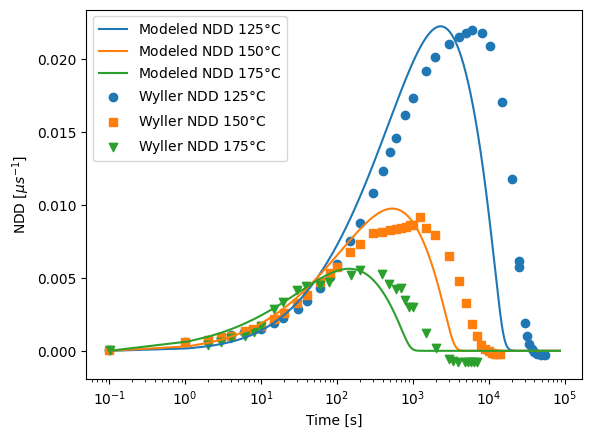

In [32]:
import itertools

fig, ax = plt.subplots()

for name, group in grouped_model:
    ax.plot(
        group["time (s)"] + 0.1,
        group["NDD-normalized"],
        label=f"Modeled NDD {name}$\degree$C",
    )
    ax.legend()


marker = itertools.cycle(("o", "s", "v", "o", "*"))

for name, group in grouped_data:
    ax.scatter(
        group["X"],
        group["Y"],
        label=f"Wyller NDD {name}$\degree$C",
        marker=next(marker),
    )
    ax.legend()

ax.set_xscale("log")

ax.set_xlabel("Time [s]")
ax.set_ylabel("NDD [$\mu s^{-1}$]")

plt.show()

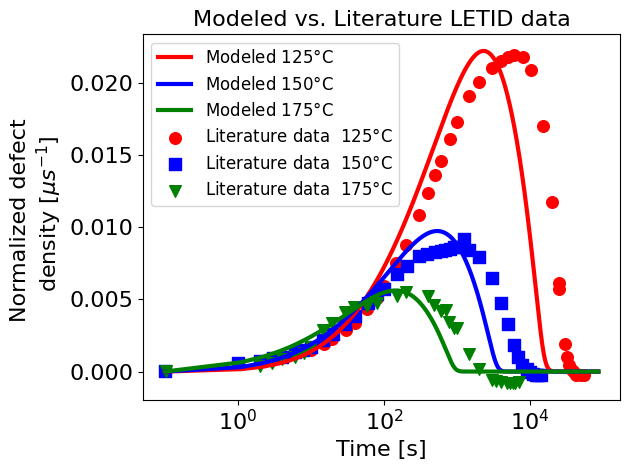

In [33]:
import itertools

fig, ax = plt.subplots()

colors = itertools.cycle(("red", "blue", "green"))

for name, group in grouped_model:
    ax.plot(
        group["time (s)"] + 0.1,
        group["NDD-normalized"],
        color=next(colors),
        label=f"Modeled {name}$\degree$C",
        linewidth=3,
    )
    ax.legend(prop={"size": 12})


marker = itertools.cycle(("o", "s", "v", "o", "*"))

for name, group in grouped_data:
    ax.scatter(
        group["X"],
        group["Y"],
        label=f"Literature data  {name}$\degree$C",
        color=next(colors),
        marker=next(marker),
        s=70,
    )
    ax.legend(prop={"size": 12})

ax.set_xscale("log")

ax.tick_params(axis="both", which="major", labelsize=16)


ax.set_xlabel("Time [s]", fontsize=16)
ax.set_ylabel("Normalized defect \n density [$\mu s^{-1}$]", fontsize=16)

ax.set_title("Modeled vs. Literature LETID data", fontsize=16)


plt.tight_layout()

# fig.savefig('wafer data.png', dpi = 600)
plt.show()